In [ ]:
import tensorflow as tf
import numpy as np
from google.cloud import storage
import matplotlib.pyplot as plt
import random
import pandas as pd
from io import BytesIO
from sklearn.model_selection import train_test_split
from typing import List, Tuple
import vertexai
from vertexai.vision_models import Image, MultiModalEmbeddingModel
from google import genai # Importar genai aquí
import os
from PIL import Image
import io
import csv
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.neighbors import NearestNeighbors
from typing import Sequence
import time
import asyncio
from sklearn.metrics.pairwise import cosine_distances
from IPython.display import HTML, Markdown, display
from google import genai
import PIL.Image

In [ ]:
# CORRER ESTA CELDA TANTO REFUGE COMO MHIST
PROJECT_ID = "[your-project-id]"
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)

if not client.vertexai:
    print(f"Using Gemini Developer API.")
elif client._api_client.project:
    print(
        f"Using Vertex AI with project: {client._api_client.project} in location: {client._api_client.location}"
    )
elif client._api_client.api_key:
    print(
        f"Using Vertex AI in express mode with API key: {client._api_client.api_key[:5]}...{client._api_client.api_key[-5:]}"
    )

Using Vertex AI with project: llms-for-biomed in location: us-central1


In [ ]:
#MODEL_ID = "gemini-2.0-flash"
#MODEL_ID = "gemini-1.5-pro"
#MODEL_ID = "gemini-2.5-flash-preview-04-17"
MODEL_ID = "gemini-2.0-flash-lite-001"
#MODEL_ID = "gemini-2.5-pro-exp-03-25"
# response = client.models.generate_content(
#     model=MODEL_ID, contents="What's the largest planet in our solar system?"
# )

# display(Markdown(response.text))

## **MHIST experiments**

Este fragmento de código se conecta a un bucket de Google Cloud Storage, descarga el CSV de anotaciones, lo carga en un DataFrame de pandas y crea una columna binaria y que vale 1 cuando la etiqueta es “SSA” y 0 en caso contrario.

In [ ]:
# 1) Parámetros de tu bucket
BUCKET_NAME    = "datasets_biomed_llm"
PREFIX_IMAGES  = "MHIST/"         # carpeta en el bucket que contiene las imágenes
PREFIX_CSV     = "MHIST/annotations_train_val_test.csv" # ruta dentro del bucket

# 2) Inicializa el cliente de GCS
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)

# 3) Descarga y carga el CSV de anotaciones
blob_csv = bucket.blob(PREFIX_CSV)
data_csv = blob_csv.download_as_bytes()
df = pd.read_csv(io.BytesIO(data_csv))

# 4) Procesa la etiqueta binaria
df["y"] = (df["Majority Vote Label"] == "SSA").astype(int)

In [ ]:
# DataFrame de entrenamiento
train_df = df[df["Partition"] == "train"].reset_index(drop=True)

# DataFrame de validación
val_df = df[df["Partition"] == "val"].reset_index(drop=True)

# DataFrame de prueba
test_df  = df[df["Partition"] == "test"].reset_index(drop=True)

In [ ]:
train_df.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aaa.png,SSA,6,train,1
1,MHIST_aab.png,HP,0,train,0
2,MHIST_aac.png,SSA,5,train,1
3,MHIST_aae.png,HP,1,train,0
4,MHIST_aaf.png,SSA,5,train,1


In [ ]:
val_df.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aai.png,HP,3,val,0
1,MHIST_aam.png,HP,0,val,0
2,MHIST_aas.png,SSA,4,val,1
3,MHIST_aat.png,HP,0,val,0
4,MHIST_aaw.png,HP,0,val,0


In [ ]:
test_df.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,y
0,MHIST_aag.png,HP,2,test,0
1,MHIST_aah.png,HP,2,test,0
2,MHIST_aaq.png,SSA,5,test,1
3,MHIST_aar.png,HP,0,test,0
4,MHIST_aay.png,HP,1,test,0


(**Esta parte tarda 9 minutos**)

In [ ]:
#5) Itera sobre el dataframe, descarga cada imagen y conviértela a array
X_list, y_list = [], []
for _, row in df.iterrows():
    img_blob = bucket.blob(PREFIX_IMAGES + row["Image Name"])
    img_bytes = img_blob.download_as_bytes()
    with Image.open(io.BytesIO(img_bytes)) as im: # PIL necesita una representación de la imagen en formato de bytes
        im = im.convert("RGB").resize((224,224))
        arr = np.array(im)
    X_list.append(arr)
    y_list.append(row["y"])

# 6) Ensambla los arrays finales
X = np.stack(X_list, axis=0)    # (N,224,224,3)
y = np.array(y_list, dtype=int) # (N,)

print(f"Cargadas {len(X)} imágenes. Distribución de etiquetas: {np.bincount(y)}")

Cargadas 3152 imágenes. Distribución de etiquetas: [2162  990]


In [ ]:
# Como X (arreglos de numpy) y y (etiquetas) contienen toda la información de imágenes y etiquetas
# Las separamos en entrenameinto y prueba

# 1) Extrae la columna "Partition" como lista
partitions = df["Partition"].values  # Tiene el mismo orden que X, y

# 3) Filtra por train o test
X_train = X[partitions == "train"]
y_train = y[partitions == "train"]

X_val = X[partitions == "val"]
y_val = y[partitions == "val"]

X_test = X[partitions == "test"]
y_test = y[partitions == "test"]

# 4) Confirmación
print("Train:", X_train.shape, np.bincount(y_train))
print("Validation:", X_val.shape, np.bincount(y_val))
print("Test: ", X_test.shape,  np.bincount(y_test))

Train: (1740, 224, 224, 3) [1236  504]
Validation: (435, 224, 224, 3) [309 126]
Test:  (977, 224, 224, 3) [617 360]


### **Funciones que se usan durante los experimentos:**

In [ ]:
# FUNCIÓN PARA CREAR LA LISTA DE MUESTRAS QUE SE LE VAN A DAR AL MODELO DE GEMINI COMO CONTEXTO

def init_examples_for_query(
        X_train: Sequence[np.ndarray],
        emb_train: np.ndarray,
        y_train: Sequence[int],
        query_emb: np.ndarray,
        n_pos: int = 3,
        n_neg: int = 3
        ) -> tuple[list[tuple[np.ndarray, int],int,int]]:
    """
    Rellena EXAMPLES con:
      - las `n_pos` muestras SSA (y==1) de train más cercanas a `query_emb`
      - las `n_neg` muestras HP  (y==0) de train más cercanas a `query_emb`

    Parámetros
    ----------
    X_train : iterable de np.ndarray
        Imágenes de entrenamiento.
    emb_train : np.ndarray, shape (N_train, D)
        Embeddings correspondientes a X_train.
    y_train : iterable de int
        Etiquetas 1 = SSA, 0 = HP de tamaño N_train.
    query_emb : np.ndarray, shape (D,)
        Embedding de la imagen de consulta.
    n_pos, n_neg : int
        Número de prototipos positivos y negativos a extraer.
    """

    # 1) Fit global k-NN
    # ESTE PASO SE PUEDE HACER FUERA DE LA FUNCIÓN Y NO SIEMPRE QUE SE HAGA UNA CONSULTA:
    knn_global = NearestNeighbors(
        n_neighbors=emb_train.shape[0], # consulta sobre toda la base
        metric="cosine",
        algorithm="brute").fit(emb_train) # Estoy es almacenando los embeddings de las imágenes para luego hacer consultas

    dists_all, idxs_all = knn_global.kneighbors([query_emb])
    idxs_sorted = idxs_all[0]
    dists_sorted = dists_all[0]

    # 2) Busco llenar las lista de indices con ejemplos postivos y negativos, aunque aquí concateno distancias en realidad no las uso más adelante
    pos_ex, neg_ex = [], [] # Listas de índices
    for dist_j, i in zip(dists_sorted, idxs_sorted):
        lbl = y_train[i]
        if lbl == 1 and len(pos_ex) < n_pos:
            pos_ex.append((i, dist_j))
        elif lbl == 0 and len(neg_ex) < n_neg:
            neg_ex.append((i, dist_j))
        if len(pos_ex) == n_pos and len(neg_ex) == n_neg:
            break
    EXAMPLES: list[tuple[np.ndarray, int, float]] = []
    for i, j in pos_ex + neg_ex:
        EXAMPLES.append((X_train[i], int(y_train[i]), j))

    return EXAMPLES, len(pos_ex), len(neg_ex)
#EXAMPLES = init_examples_for_query(X_train, emb_train, y_train, emb_test[0], n_pos=3, n_neg=3)

In [ ]:
# FUNCIÓN PARA CREAR LA LISTA DE MUESTRAS QUE SE LE VAN A DAR AL MODELO DE GEMINI COMO CONTEXTO

def get_knn_neighbors(
        X_train: Sequence[np.ndarray],
        emb_train: np.ndarray,
        y_train: Sequence[int],
        query_emb: np.ndarray,
        n: int = 5
        ) -> tuple[list[tuple[np.ndarray, int],int,int]]:
    """
    Rellena EXAMPLES con:
      - las `n_pos` muestras SSA (y==1) de train más cercanas a `query_emb`
      - las `n_neg` muestras HP  (y==0) de train más cercanas a `query_emb`

    Parámetros
    ----------
    X_train : iterable de np.ndarray
        Imágenes de entrenamiento.
    emb_train : np.ndarray, shape (N_train, D)
        Embeddings correspondientes a X_train.
    y_train : iterable de int
        Etiquetas 1 = SSA, 0 = HP de tamaño N_train.
    query_emb : np.ndarray, shape (D,)
        Embedding de la imagen de consulta.
    n_pos, n_neg : int
        Número de prototipos positivos y negativos a extraer.
    """

    # 1) Fit global k-NN
    # ESTE PASO SE PUEDE HACER FUERA DE LA FUNCIÓN Y NO SIEMPRE QUE SE HAGA UNA CONSULTA:
    knn_global = NearestNeighbors(
        n_neighbors=emb_train.shape[0], # consulta sobre toda la base
        metric="cosine",
        algorithm="brute").fit(emb_train) # Estoy es almacenando los embeddings de las imágenes para luego hacer consultas

    dists_all, idxs_all = knn_global.kneighbors([query_emb])
    idxs_sorted = idxs_all[0]
    dists_sorted = dists_all[0]

    result = []
    for dist_j, i in zip(dists_sorted, idxs_sorted):
        lbl = y_train[i]
        result.append((X_train[i], int(lbl), dist_j))

    return result[:n]

In [ ]:
len(get_knn_neighbors(X_train, emb_train, y_train, emb_test[2], n=5))

5

In [ ]:
from operator import ne
def knn_classify(
    X_train: Sequence[np.ndarray],
    emb_train: np.ndarray,
    y_train: Sequence[int],
    query_emb: np.ndarray, # Embeddings de consultas
    k: int = 5
    ) -> int:
    y_pred = []

    for query_test in query_emb:
        neighbors = get_knn_neighbors(X_train, emb_train, y_train, query_test, k)
        labels = [neighbor[1] for neighbor in neighbors]
        counts = np.bincount(labels)
        y_pred.append(np.argmax(counts))

    return y_pred

In [ ]:
# y_test

In [ ]:
y_pred_test = knn_classify(X_train, emb_train, y_train, emb_test, k=5)

In [ ]:
sum(y_pred_test)

329

In [ ]:
# Generate a classification report
report = classification_report(y_test, y_pred_test)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       617
           1       0.85      0.78      0.81       360

    accuracy                           0.87       977
   macro avg       0.86      0.85      0.86       977
weighted avg       0.87      0.87      0.87       977



In [ ]:
from google.genai import types

async def ask_gemini_polyp_fewshot_async(
    image: np.ndarray,
    semaphore: asyncio.Semaphore,
    request_timeout: int = 60,
    muestras: list[tuple[np.ndarray, int]] = None
) -> dict:
    """
    Versión async de ask_gemini_polyp_fewshot.
    Usa `semaphore` para limitar concurrencia y `await asyncio.to_thread` para no bloquear.
    """
    if not muestras:
        raise ValueError(
            "muestras está vacío. Usa set_examples(...) o init_examples_from_dataset(...)"
        )

    #1) Convierte NumPy a PIL.Image (igual que antes)
    img_pil = (
        PIL.Image.fromarray((image * 255).astype(np.uint8))
        if image.max() <= 1
        else PIL.Image.fromarray(image.astype(np.uint8))
    )

    # 2) Construye la lista contents con few-shot examples (idéntico)
    text1 = types.Part.from_text(text="""Analyze the query image based on the following steps:

    1.  Carefully examine the provided example images and their corresponding labels ('SSA' or 'HP').
    2.  Identify key features in the example images associated with each class (SSA and HP), such as crypt distortion,
    goblet cell mucin depletion, branching crypts, and serrated architecture.
    3.  Analyze the query image, looking for the same key features identified in the example images.
    4.  Based on the presence or absence of key features and the example images, classify the query image as either 'SSA' or 'HP'.

    Here are the example images with corresponding labels using
    the following format: <image file> label: <image label>

    EXAMPLES:
    """)
    text2 = types.Part.from_text(text="""  QUERY IMAGE:""")
    text3 = types.Part.from_text(text="""  Based on the examples provided, what is the class of the query image?""")
    si_text1 = """You are an expert medical AI assistant trained in histopathology.
    Your task is to analyze microscopic images of colon tissue and classify them as either
    'SSA' (Sessile Serrated Adenoma) or 'HP' (Healthy Polyp).
    HPs are typically benign, while sessile serrated adenomas (SSAs) are precancerous
    lesions that can turn into cancer if left untreated and require sooner follow-up examinations.
    It is very important that your final decision classification be in the format "classification: <what you consider>" at last of your response.
    """

    contents: list[object] = []
    contents.append(text1)
    for idx, (ex_img, label, distance) in enumerate(muestras, 1):
        ex_pil = (
            PIL.Image.fromarray((ex_img * 255).astype(np.uint8))
            if ex_img.max() <= 1
            else PIL.Image.fromarray(ex_img.astype(np.uint8))
        )
        contents.append(ex_pil)
        contents.append(f" label : {'SSA' if label == 1 else 'HP'} \n")

    # Añade la imagen candidata
    contents.append(text2)
    contents.append(img_pil)
    contents.append(text3)

    generate_content_config = types.GenerateContentConfig(
    system_instruction=[types.Part.from_text(text=si_text1)])

    # 3) Llamada bloqueante al API dentro de to_thread + timeout, protegida por semaphore
    async with semaphore:
        try:
            response = await asyncio.wait_for(
                asyncio.to_thread(
                    lambda: client.models.generate_content(
                        model=MODEL_ID,
                        contents=contents,
                        config=generate_content_config
                    )
                ),
                timeout=request_timeout
            )

        except asyncio.TimeoutError as e:
            print(f"⚠️ Timeout tras {request_timeout}s en few-shot image")
            raise
        except Exception as e:
            print(f"⚠️ Error few-shot Gemini: {e}")
            raise


    # 4) Post-procesado de la respuesta (igual que antes)
    raw = response.text.strip().lower()
    segment = raw[-20:]
    if "classification: ssa" in segment:
      pred = 1
    elif "classification: hp" in segment:
      pred = 0
    else:
      pred = -1
    # raw = response.text.strip().lower()
    # pred = 1 if "ssa" in raw[len(raw)-20:] else 0 #1 if "ssa" in raw else 0

    return {
        "prompt": si_text1,#instruction,
        "raw_response": raw,
        "predicted_class": pred,
        "n_muestras": len(muestras)
    }

In [ ]:
# create a script to evaluate the function ask_gemini_polyp_fewshot_async for some images
# choose 10 random samples from X
indices = np.random.choice(X_test.shape[0], size=10, replace=False)
X_samples = X_test[indices]
y_samples = y_test[indices]

In [ ]:
y_samples

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0])

In [ ]:
# for each sample
for image, label, indice in zip(X_samples,y_samples, indices):
    print('===================================COMIENZO=============================================')
    EXAMPLES = get_knn_neighbors(X_train, emb_train, y_train, emb_test[indice], n=6) #init_examples_for_query(X_train, emb_train, y_train, emb_test[indice], n_pos=3, n_neg=3)
    # evaluate the function
    result = await ask_gemini_polyp_fewshot_async(image=image, semaphore=asyncio.Semaphore(1),muestras=EXAMPLES)
    # print the result
    print('Respuesta de gemini:',result['raw_response'])
    print('Clase predicha:', result['predicted_class'])
    print('Clase real:', label)
    print('====================================FIN=============================================')

===================================COMIENZO=============================================
Respuesta de gemini: here's an analysis of the query image:

*   **key features of ssa:**  the example ssa images show characteristic features: distorted crypts, serrated architecture (sawtooth-like appearance of crypts), and sometimes branching crypts.
*   **key features of hp:** the example hp images show relatively uniform crypts without significant distortion or serration.

*   **query image analysis:** the query image shows features consistent with ssa. there is some crypt distortion and the crypts have a slightly serrated appearance.

classification: ssa
Clase predicha: 1
Clase real: 1
====================================FIN=============================================
===================================COMIENZO=============================================
Respuesta de gemini: the query image exhibits features consistent with sessile serrated adenoma (ssa). the crypts show a distorted and ser

In [ ]:
def evaluate_polyp_classifier(y_true, y_pred, probas=None):
    """
    Evaluates a polyp classifier.
    """
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
    }

    if probas is not None:
        try:
            metrics["AUC"] = roc_auc_score(y_true, probas)
        except ValueError:
            metrics["AUC"] = "Undefined (only one class present in y_true)"

    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)

    return metrics, cm, report

In [ ]:
def stratified_sample_from_mhist(X, y, fraction: float):
    """
    Extracts a stratified sample from the MHIST dataset based on the given fraction.

    Args:
        X (np.ndarray): Array of images.
        y (np.ndarray): Array of labels.
        fraction (float): Fraction of dataset to use for testing (0 < fraction <= 1).

    Returns:
        Tuple[np.ndarray, np.ndarray]: Sampled images and labels.
    """
    if not (0 < fraction <= 1):
        raise ValueError("Fraction must be between 0 and 1.")

    X_sampled, _, y_sampled, _ = train_test_split(
        X, y, train_size=fraction, stratify=y, random_state=42
    )
    return X_sampled, y_sampled

In [ ]:
async def evaluate_classifier_on_sample(
    X, y, embeddings,           # embeddings de X (test)
    X_train, emb_train, y_train,# datos y embeddings de train
    n: int, #n_pos: int, n_neg: int,     # cuántos prototipos de cada clase
    fraction: float,
    classifier_func,
    verbose: bool = False
) ->  dict:
    """
    Igual que antes, pero ahora para cada imagen de test:
    1) Extrae su embedding de `embeddings`
    2) Llama a init_examples_for_query(X_train, emb_train, y_train, query_emb, n_pos, n_neg)
    3) Encola la tarea de clasificación usando esos ejemplos contextuales
    """
    # 1) Sampleo estratificado si aplica
    if 0 < fraction < 1:
        X_sampled, y_sampled = stratified_sample_from_mhist(X, y, fraction)
        emb_sampled, _      = stratified_sample_from_mhist(embeddings, y, fraction)
    elif fraction == 1.0:
        X_sampled, y_sampled, emb_sampled = X, y, embeddings
    else:
        raise ValueError("Fraction must be between 0 and 1 (inclusive of 1.0).")

    start_time = time.time()

    # ── Inicializa los acumuladores de muestras ──
    all_pos, all_neg = [], []

    # 2) Prepara y lanza tareas
    tasks = []

    for idx, image in enumerate(X_sampled):
       # Embedding de imagen a la que se le busca los vecinos más cercanos
        query_emb = emb_sampled[idx]

        # AQUÍ SE USA LA FUNCIÓN DE LAS MUESTRAS PORQUE AHORA POR CADA IMAGEN SE HACE UNA BÚSQUEDA DE K VECINOS MÁS CERCANOS
        examples =get_knn_neighbors(       #, pos_count, neg_count = init_examples_for_query(
        X_train, emb_train, y_train,
        query_emb, n#n_pos, n_neg
        )
        # ────────────────────────────────────────────────────

        # Acumula
        # all_pos.append(pos_count)
        # all_neg.append(neg_count)

        # if verbose:
        #   print(f"📝 Prototipos SSA {pos_count}/{n_pos}, HP {neg_count}/{n_neg}")
        # examples.clear()
        # for i in chosen:
        #     examples.append((X_train[i], int(y_train[i])))
        tasks.append(asyncio.create_task(
            classifier_func(image=image, muestras = examples)
        ))

    # 3) Espera todas las tareas
    results = await asyncio.gather(*tasks, return_exceptions=True)

    # ── Nuevo bloque: imprime los promedios de prototipos ──
    # avg_pos = np.mean(all_pos)
    # avg_neg = np.mean(all_neg)
    # print(f"📝 Promedio prototipos por imagen: SSA {avg_pos:.1f}/{n_pos}, HP {avg_neg:.1f}/{n_neg}")

    # 4) Estadísticas básicas
    n_total  = len(results)
    n_errors = sum(1 for r in results if isinstance(r, Exception))
    n_success= n_total - n_errors
    print(f"📊 Total: {n_total}, ✅ Éxitos: {n_success}, ❌ Fallos: {n_errors}")
    if verbose and n_errors>0:
        print(f"❌ Aviso: {n_errors} imágenes fallaron en la clasificación.")

    # 5) Procesa resultados
    y_preds = []#, probas = [], []
    for idx, res in enumerate(results):
        if isinstance(res, Exception):
            if verbose:
                print(f"❌ Error processing image {idx+1}: {res}")
            y_preds.append(0)
            #probas.append(0.0)
        else:
            pred = res["predicted_class"]
            y_preds.append(pred)
            #probas.append(1.0 if pred == 1 else 0.0)

    duration = time.time() - start_time
    if True:
        print(f"✅ Evaluation completed in {duration:.2f}s")

    # 6) Métricas finales
    metrics, cm, report = evaluate_polyp_classifier(y_sampled, y_preds)#, probas)

    return {
        "metrics": metrics,
        "confusion_matrix": cm,
        "report": report,
        "y_true": y_sampled,
        "y_pred": y_preds
    }

**Resumen de las funciones:**
  1. init_examples_from_dataset (crea las muestras de contexto).
  2. ask_gemini_polyp_fewshot_async (clasifica una imagen usando Gemini con ejemplos few-shot, se apoya en un resultado de 1).
  3. evaluate_polyp_classifier (arroja métricas, matriz de confusión, reporte de un clasificador).
  4. stratified_sample_from_mhist (extrae una muestra estratificada y etiquetas).
  5. evaluate_classifier_on_sample (evalúa un clasificador sobre una muestra estratificada de MHIST, usa a 4, usa a 3 y llama a 1 en el experimento).

## **INICIO EXPERIMENTOS MHIST**

### ***Few-shot con muestras dadas por KNN en varias corridas con distintos tamaños de shots: 8, 16 y 32***

#### ***Cargue de embeddings de ResNet18***

In [ ]:
# 1) Descargando el archivo de embaddings al entorno de Colab
!gsutil cp gs://datasets_biomed_llm/MHIST/features_mhist.npz .

Copying gs://datasets_biomed_llm/MHIST/features_mhist.npz...
- [1 files][  1.7 MiB/  1.7 MiB]                                                
Operation completed over 1 objects/1.7 MiB.                                      


In [ ]:
# 3) Manipulando el features_mhist.npz, como extrayendo la información que tiene
data = np.load("features_mhist.npz", allow_pickle=True)
paths      = data["paths"]       # lista de rutas de cada imagen
filenames_npz = np.array([p.split("/")[-1] for p in paths])
labels_npz = data["labels"]      # vector de etiquetas (HP o SSA)
embeddings_npz = data["embeddings"]  # matriz de shape (N, D)

print('Lo que traen los embeddings:', data.keys())
print("Nombres de ejemplo:", paths[:1])
print("Embeddings shape:", embeddings_npz.shape)
print("Distribución de test, train y val:", np.unique(labels_npz, return_counts=True))
print("Nombres de archivos:", filenames_npz[:2])

Lo que traen los embeddings: KeysView(NpzFile 'features_mhist.npz' with keys: paths, labels, embeddings)
Nombres de ejemplo: ['data/patches/test/HP/MHIST_aag.png']
Embeddings shape: (3152, 128)
Distribución de test, train y val: (array([0, 1, 2]), array([ 977, 1740,  435]))
Nombres de archivos: ['MHIST_aag.png' 'MHIST_aah.png']


In [ ]:
# 1) Recreamos la partición desde las rutas
partitions = np.array([p.split("/")[-3] for p in paths])  # 'train', 'val' o 'test'

# 2) Arreglo de booleanos para train, val o prueba
mask_train = partitions == "train"
mask_val   = partitions == "val"
mask_test  = partitions == "test"

# filenames_npz son los nombres de las imágenes (definido en la celda anterior),
# luego creo diccionarios con nombres de imágenes como claves  e indices como valor

file_train_npz = filenames_npz[mask_train] # lista de nombres de imágenes de train
pos_train_dict = { fname: i for i, fname in enumerate(file_train_npz) } # diccionarios con nombres de imágenes como claves  e indices como valor

file_val_npz = filenames_npz[mask_val]
pos_val_dict = { fname: i for i, fname in enumerate(file_val_npz) }

file_test_npz = filenames_npz[mask_test]
pos_test_dict = { fname: i for i, fname in enumerate(file_test_npz) }

Alineación de embeddings y el dataframe inicial:

In [ ]:
file_train_df = train_df["Image Name"].tolist()
n_train = len(file_train_df)
D = embeddings_npz.shape[1] # dimensión de cada vector de embedding
emb_train = np.zeros((n_train, D), dtype=embeddings_npz.dtype) # arreglo vacio donde voy a poner los embeddings de train

# Para cada imagen en alguno de los dataframes, le localizo el indice en el diccionario correspondiente
# y uso ese indice
for k, fname in enumerate(file_train_df):
    pos = pos_train_dict[fname]
    emb_train[k] = embeddings_npz[mask_train][pos]


file_val_df = val_df["Image Name"].tolist()
n_val = len(file_val_df)
emb_val = np.zeros((n_val, D), dtype=embeddings_npz.dtype)

for k, fname in enumerate(file_val_df):
    pos = pos_val_dict[fname]
    emb_val[k] = embeddings_npz[mask_val][pos]


file_test_df = test_df["Image Name"].tolist()
n_test = len(file_test_df)
emb_test = np.zeros((n_test, D), dtype=embeddings_npz.dtype)

for k, fname in enumerate(file_test_df):
    pos = pos_test_dict[fname]
    emb_test[k] = embeddings_npz[mask_test][pos]

Renderizar la imagen de query vs las más cercanas y ver si se parecen:

In [ ]:
test_idx = 972

query_image = X_test[test_idx]       # imagen de consulta
query_emb   = emb_test[test_idx]     # correspondiente embedding de consulta


# --------------------------------------------------
# 3) Llama a la función para obtener 3 positivos (etiqueta=1) y 3 negativos (etiqueta=0)
# --------------------------------------------------
EXAMPLES, n_pos_real, n_neg_real = init_examples_for_query(
    X_train=X_train,
    emb_train=emb_train,
    y_train=y_train,
    query_emb=query_emb,
    n_pos=3,
    n_neg=3
)

print(f"Se recuperaron {n_pos_real} vecinos de clase 1 y {n_neg_real} vecinos de clase 0.")
# EXAMPLES es una lista de tuplas (imagen, etiqueta), con largo = n_pos_real + n_neg_real = 6 (si hay suficientes).

EXAMPLES_sorted = sorted(EXAMPLES, key=lambda tpl: tpl[2])

# --------------------------------------------------
# 4) Visualiza la imagen de consulta y sus 6 vecinos
# --------------------------------------------------
fig = plt.figure(figsize=(10, 4))

# A) Mostrar la imagen de consulta en la primera posición
ax0 = fig.add_subplot(1, 7, 1)
ax0.imshow(query_image.astype("uint8"))
ax0.set_title(f"Consulta\n(Imágen de test)\nEtiqueta={y_test[test_idx]}")
ax0.axis("off")

# B) Mostrar cada uno de los 6 ejemplos devueltos
for idx, (img_vecina, etiqueta, distance) in enumerate(EXAMPLES_sorted, start=2):
    ax = fig.add_subplot(1, 7, idx)
    ax.imshow(img_vecina.astype("uint8"))
    ax.set_title(f"Vecino {idx-1}\nEtiqueta={etiqueta}\nDistance\n={distance:1.8f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

NameError: name 'init_examples_for_query' is not defined

#### ***Experimento sobre varias corridas***

In [ ]:
# Evaluación few-shot en múltiples corridas

PREFIX_RESULTS = "MHIST/Experimentos/Baseline_knn_general_MHIST/"

# Descripción:
# Este bloque repite N veces la evaluación few-shot para varios modelos y tamaños de “shots”,
# calcula Accuracy, Precision, Recall, F1 (y AUC si está disponible) en cada corrida,
# y devuelve un DataFrame con una fila por (run, modelo, n_shots).

from functools import partial

# Modelos a evaluar
models = [
    "gemini-2.0-flash",
    # "gemini-2.5-flash-preview-04-17"
]

sem = asyncio.Semaphore(30)
n_shots_list = [8,8,8,8,8, 16,16,16,16,16, 32,32,32,32,32]
results = []
run_id = 0



for model in models:
    MODEL_ID = model

    for n_shots in n_shots_list:
        run_id += 1
        print(f"✅ EXAMPLES inicializado con {n_shots} imágenes.")
          #f"({n_shots//2} precancerosas, {n_shots//2} normales).")

        # Llamada corregida a evaluate_classifier_on_sample:
        res = await evaluate_classifier_on_sample(
            X         = X_test,
            y         = y_test,
            embeddings= emb_test,       # embeddings de test
            X_train   = X_train,
            emb_train = emb_train,      # embeddings de train
            y_train   = y_train,
            n           = n_shots,
            # n_pos     = n_shots // 2,
            # n_neg     = n_shots // 2,
            fraction  = 1.0,
            classifier_func = partial(
                ask_gemini_polyp_fewshot_async,
                semaphore=sem
            ),
            verbose   = False
        )

        # ———> CREACIÓN DE CSV DE PREDICCIONES Y SUBIDA A GCS <———
        # Extraemos predicciones y etiquetas verdaderas
        y_true = res["y_true"]
        y_pred = res["y_pred"]

        # Construimos el DataFrame de predicciones
        df_preds = pd.DataFrame({
            "run_id":     [run_id] * len(y_true),
            "model":      [model]   * len(y_true),
            "n_shots":    [n_shots] * len(y_true),
            "sample_idx": list(range(len(y_true))),
            "y_true":     y_true,
            "y_pred":     y_pred
        })

        # Nombre del CSV
        csv_name = f"predictions_run{run_id}_{model}_{n_shots}.csv"

        # Lo volcamos a un buffer en memoria
        csv_buffer = io.StringIO()
        df_preds.to_csv(csv_buffer, index=False)

        # Subimos el buffer como blob al bucket
        blob_path = PREFIX_RESULTS + csv_name
        blob = bucket.blob(blob_path)
        blob.upload_from_string(csv_buffer.getvalue(), content_type="text/csv")

        print(f"✅ Subido CSV de predicciones a gs://{BUCKET_NAME}/{blob_path}")
        # ———> FIN subida de CSV <———


        metrics = res["metrics"]

        # Extraemos la matriz de confusión
        cm = res["confusion_matrix"]
        tn, fp, fn, tp = cm.ravel()

        results.append({
            "model":    model,
            "n_shots":  n_shots,
            "Accuracy": metrics["Accuracy"],
            "Precision":metrics["Precision"],
            "Recall":   metrics["Recall"],
            "F1 Score": metrics["F1 Score"],
            "TN":       tn,
            "FP":       fp,
            "FN":       fn,
            "TP":       tp
        })

df_results = pd.DataFrame(results)
df_results

✅ EXAMPLES inicializado con 8 imágenes.
⚠️ Timeout tras 60s en few-shot image
📊 Total: 977, ✅ Éxitos: 976, ❌ Fallos: 1
✅ Evaluation completed in 150.82s
✅ Subido CSV de predicciones a gs://datasets_biomed_llm/MHIST/Experimentos/Baseline_knn_general_MHIST/predictions_run1_gemini-2.0-flash_8.csv
✅ EXAMPLES inicializado con 8 imágenes.
📊 Total: 977, ✅ Éxitos: 977, ❌ Fallos: 0
✅ Evaluation completed in 114.69s
✅ Subido CSV de predicciones a gs://datasets_biomed_llm/MHIST/Experimentos/Baseline_knn_general_MHIST/predictions_run2_gemini-2.0-flash_8.csv
✅ EXAMPLES inicializado con 8 imágenes.
📊 Total: 977, ✅ Éxitos: 977, ❌ Fallos: 0
✅ Evaluation completed in 134.03s
✅ Subido CSV de predicciones a gs://datasets_biomed_llm/MHIST/Experimentos/Baseline_knn_general_MHIST/predictions_run3_gemini-2.0-flash_8.csv
✅ EXAMPLES inicializado con 8 imágenes.
📊 Total: 977, ✅ Éxitos: 977, ❌ Fallos: 0
✅ Evaluation completed in 112.21s
✅ Subido CSV de predicciones a gs://datasets_biomed_llm/MHIST/Experimentos/B

,model,n_shots,Accuracy,Precision,Recall,F1 Score,TN,FP,FN,TP
0,gemini-2.0-flash,8,0.720573,0.582857,0.850000,0.691525,398,219,54,306
1,gemini-2.0-flash,8,0.713408,0.576046,0.841667,0.683973,394,223,57,303
2,gemini-2.0-flash,8,0.725691,0.589494,0.841667,0.693364,406,211,57,303
3,gemini-2.0-flash,8,0.719550,0.582375,0.844444,0.689342,399,218,56,304
4,gemini-2.0-flash,8,0.706244,0.568224,0.844444,0.679330,386,231,56,304
5,gemini-2.0-flash,16,0.712385,0.572744,0.863889,0.688815,385,232,49,311
6,gemini-2.0-flash,16,0.732856,0.591497,0.888889,0.710322,396,221,40,320
7,gemini-2.0-flash,16,0.717503,0.576923,0.875000,0.695364,386,231,45,315
8,gemini-2.0-flash,16,0.726714,0.587571,0.866667,0.700337,398,219,48,312
9,gemini-2.0-flash,16,0.734903,0.594747,0.880556,0.709966,401,216,43,317


In [ ]:
# Parámetros del bucket y carpeta donde están los CSV:
BUCKET_NAME    = "datasets_biomed_llm"
PREFIX_CSV     = "MHIST/Experimentos/Baseline_knn_general_MHIST/"

# -------------------------------------------------------
# 2) Inicializa el cliente de GCS
# -------------------------------------------------------

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

# -------------------------------------------------------
# 3) Recorre todos los blobs bajo PREFIX_CSV y descarga cada CSV
# -------------------------------------------------------
records = []

# Listamos todos los blobs que empiecen con el prefijo
for blob in bucket.list_blobs(prefix=PREFIX_CSV):
    # Solo nos interesan los archivos .csv
    if not blob.name.endswith(".csv"):
        continue

    # 3.1) Descarga el CSV en memoria
    csv_bytes = blob.download_as_string()
    df_preds  = pd.read_csv(BytesIO(csv_bytes))

    # 3.2) Extrae la información básica (run_id, model, n_shots)
    #      Asumimos que cada CSV tiene estas columnas:
    #          "run_id", "model", "n_shots", "sample_idx", "y_true", "y_pred"
    run_id  = int(df_preds["run_id"].iloc[0])
    model   = df_preds["model"].iloc[0]
    n_shots = int(df_preds["n_shots"].iloc[0])

    # 3.3) Extrae vectores de y_true y y_pred
    y_true = df_preds["y_true"].values
    y_pred = df_preds["y_pred"].values

    # -------------------------------------------------------
    # 4) Calcula métricas para este CSV
    # -------------------------------------------------------
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    cm   = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

     # 4.1) Obtener el classification_report en dict para sacar métricas por clase
    report_dict = classification_report(
        y_true,
        y_pred,
        labels=[0, 1],
        output_dict=True,
        zero_division=0
    )  # <-- INTRODUCIR

    # Extraer macro‐F1 y weighted‐F1
    macro_f1    = float(report_dict["macro avg"]["f1-score"])       # <-- INTRODUCIR
    weighted_f1 = float(report_dict["weighted avg"]["f1-score"])    # <-- INTRODUCIR

    # Extraer soporte (support) de cada clase
    support_0 = int(report_dict["0"]["support"])    # <-- INTRODUCIR
    support_1 = int(report_dict["1"]["support"])    # <-- INTRODUCIR

    # 4.2) Agregar DOS filas: una para clase 0 y otra para clase 1 (formato “long”)
    for clase in [0, 1]:
        precision_clase = float(report_dict[str(clase)]["precision"])   # <-- INTRODUCIR
        recall_clase    = float(report_dict[str(clase)]["recall"])      # <-- INTRODUCIR
        f1_clase        = float(report_dict[str(clase)]["f1-score"])    # <-- INTRODUCIR
        support_clase   = int(report_dict[str(clase)]["support"])       # <-- INTRODUCIR

        records.append({
            "run_id":      run_id,               # conserva run_id
            "model":       model,                # conserva model
            "n_shots":     n_shots,              # conserva n_shots
            "clase":       clase,                # etiqueta de clase (0 o 1)
            "precision":   precision_clase,      # métrica de esta clase
            "recall":      recall_clase,         # métrica de esta clase
            "f1":          f1_clase,             # métrica de esta clase
            "accuracy":    acc,                  # accuracy global (repetido)
            "macro_f1":    macro_f1,             # macro‐F1 (repetido)
            "weighted_f1": weighted_f1,           # weighted‐F1 (repetido)
            "tn":          tn,                   # valor de TN (repetido)
            "fp":          fp,                   # valor de FP (repetido)
            "fn":          fn,                   # valor de FN (repetido)
            "tp":          tp,                   # valor de TP (repetido)
            "support":     support_clase,        # soporte de esta clase
        })

# -------------------------------------------------------
# 6) Construye el DataFrame final y muéstralo
# -------------------------------------------------------
df_results = pd.DataFrame.from_records(records)

df_results.sort_values(by=["run_id"], inplace=True)
df_results

,run_id,model,n_shots,clase,precision,recall,f1,accuracy,macro_f1,weighted_f1,tn,fp,fn,tp,support
0,1,gemini-2.0-flash,8,0,0.869919,0.693679,0.771867,0.741044,0.736229,0.745604,428,189,64,296,617
1,1,gemini-2.0-flash,8,1,0.610309,0.822222,0.700592,0.741044,0.736229,0.745604,428,189,64,296,360
2,2,gemini-2.0-flash,16,0,0.882937,0.721232,0.793934,0.763562,0.758312,0.767682,445,172,59,301,617
3,2,gemini-2.0-flash,16,1,0.636364,0.836111,0.722689,0.763562,0.758312,0.767682,445,172,59,301,360
4,3,gemini-2.0-flash,32,0,0.896154,0.755267,0.819701,0.790174,0.784391,0.793680,466,151,54,306,617
5,3,gemini-2.0-flash,32,1,0.669584,0.850000,0.749082,0.790174,0.784391,0.793680,466,151,54,306,360


In [ ]:
# Resumen para n_shots = 8
df8 = df_results[df_results['n_shots'] == 8]

# Métricas globales (una fila por run_id)
df8_global = (
    df8[['run_id','accuracy','macro_f1','weighted_f1']]
    .drop_duplicates(subset=['run_id'])
)
stats8_global = df8_global[['accuracy','macro_f1','weighted_f1']].agg(['mean','std'])

print("=== Global metrics for 8 shots (mean ± std) ===")
for m in stats8_global.columns:
    print(f"{m:12s}: {stats8_global.loc['mean',m]:.4f} ± {stats8_global.loc['std',m]:.4f}")

# Métricas por clase
stats8_class = df8.groupby('clase')[['precision','recall','f1']].agg(['mean','std'])

print("\n=== Per-class metrics for 8 shots (mean ± std) ===")
for cls in stats8_class.index:
    print(f"\nClase {cls}:")
    for m in ['precision','recall','f1']:
        print(f"  {m:9s}: {stats8_class.loc[cls,(m,'mean')]:.4f} ± {stats8_class.loc[cls,(m,'std')]:.4f}")

=== Global metrics for 8 shots (mean ± std) ===
accuracy    : 0.7441 ± nan
macro_f1    : 0.7391 ± nan
weighted_f1 : 0.7486 ± nan

=== Per-class metrics for 8 shots (mean ± std) ===

Clase 0:
  precision: 0.8707 ± nan
  recall   : 0.6985 ± nan
  f1       : 0.7752 ± nan

Clase 1:
  precision: 0.6141 ± nan
  recall   : 0.8222 ± nan
  f1       : 0.7031 ± nan


In [ ]:
# Resumen para n_shots = 16
df16 = df_results[df_results['n_shots'] == 16]

# Métricas globales (una fila por run_id)
df16_global = (
    df16[['run_id','accuracy','macro_f1','weighted_f1']]
    .drop_duplicates(subset=['run_id'])
)
stats16_global = df16_global[['accuracy','macro_f1','weighted_f1']].agg(['mean','std'])

print("=== Global metrics for 16 shots (mean ± std) ===")
for m in stats16_global.columns:
    print(f"{m:12s}: {stats16_global.loc['mean',m]:.4f} ± {stats16_global.loc['std',m]:.4f}")

# Métricas por clase
stats16_class = df16.groupby('clase')[['precision','recall','f1']].agg(['mean','std'])

print("\n=== Per-class metrics for 16 shots (mean ± std) ===")
for cls in stats16_class.index:
    print(f"\nClase {cls}:")
    for m in ['precision','recall','f1']:
        print(f"  {m:9s}: {stats16_class.loc[cls,(m,'mean')]:.4f} ± {stats16_class.loc[cls,(m,'std')]:.4f}")

=== Global metrics for 16 shots (mean ± std) ===
accuracy    : 0.6315 ± nan
macro_f1    : 0.3871 ± nan
weighted_f1 : 0.4889 ± nan

=== Per-class metrics for 16 shots (mean ± std) ===

Clase 0:
  precision: 0.6315 ± nan
  recall   : 1.0000 ± nan
  f1       : 0.7742 ± nan

Clase 1:
  precision: 0.0000 ± nan
  recall   : 0.0000 ± nan
  f1       : 0.0000 ± nan


In [ ]:
# Resumen para n_shots = 32
df32 = df_results[df_results['n_shots'] == 32]

# Métricas globales (una fila por run_id)
df32_global = (
    df32[['run_id','accuracy','macro_f1','weighted_f1']]
    .drop_duplicates(subset=['run_id'])
)
stats32_global = df32_global[['accuracy','macro_f1','weighted_f1']].agg(['mean','std'])

print("=== Global metrics for 32 shots (mean ± std) ===")
for m in stats32_global.columns:
    print(f"{m:12s}: {stats32_global.loc['mean',m]:.4f} ± {stats32_global.loc['std',m]:.4f}")

# Métricas por clase
stats32_class = df32.groupby('clase')[['precision','recall','f1']].agg(['mean','std'])

print("\n=== Per-class metrics for 32 shots (mean ± std) ===")
for cls in stats32_class.index:
    print(f"\nClase {cls}:")
    for m in ['precision','recall','f1']:
        print(f"  {m:9s}: {stats32_class.loc[cls,(m,'mean')]:.4f} ± {stats32_class.loc[cls,(m,'std')]:.4f}")

=== Global metrics for 32 shots (mean ± std) ===
accuracy    : 0.6315 ± nan
macro_f1    : 0.3871 ± nan
weighted_f1 : 0.4889 ± nan

=== Per-class metrics for 32 shots (mean ± std) ===

Clase 0:
  precision: 0.6315 ± nan
  recall   : 1.0000 ± nan
  f1       : 0.7742 ± nan

Clase 1:
  precision: 0.0000 ± nan
  recall   : 0.0000 ± nan
  f1       : 0.0000 ± nan


ValueError: x and y must have same first dimension, but have shapes (2,) and (3,)

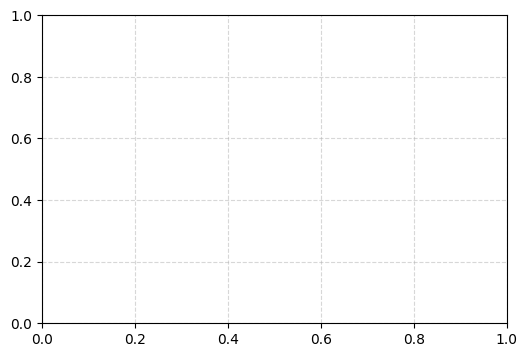

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_results.copy()

# Configuración de estilo
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["lines.marker"] = 'o'
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = '--'
plt.rcParams["grid.alpha"] = 0.5

# Obtén la lista ordenada de run_id
runs = sorted(df["run_id"].unique())
color_clase = {0: "#1f77b4", 1: "#ff7f0e"}

# --------------------------------------------------------
# 1) Gráfico de PRECISIÓN (ambas clases)
# --------------------------------------------------------
plt.figure()
for clase in [0, 1]:
    subset = df[df["clase"] == clase].sort_values("run_id")
    valores = subset["precision"].values
    plt.plot(runs, valores, color=color_clase[clase], label=f"Precisión (clase {clase})")

plt.title("Precisión por run_id (clase 0 y clase 1)")
plt.xlabel("run_id")
plt.ylabel("Valor de Precisión")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.axvline(x=5, color="gray", linestyle="--")
plt.axvline(x=10, color="gray", linestyle="--")
plt.show()

# --------------------------------------------------------
# 2) Gráfico de RECALL (ambas clases)
# --------------------------------------------------------
plt.figure()
for clase in [0, 1]:
    subset = df[df["clase"] == clase].sort_values("run_id")
    valores = subset["recall"].values
    plt.plot(runs, valores, color=color_clase[clase], label=f"Recall (clase {clase})")

plt.title("Recall por run_id (clase 0 y clase 1)")
plt.xlabel("run_id")
plt.ylabel("Valor de Recall")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.axvline(x=5, color="gray", linestyle="--")
plt.axvline(x=10, color="gray", linestyle="--")
plt.show()

# --------------------------------------------------------
# 3) Gráfico de F1 (ambas clases)
# --------------------------------------------------------
plt.figure()
for clase in [0, 1]:
    subset = df[df["clase"] == clase].sort_values("run_id")
    valores = subset["f1"].values
    plt.plot(runs, valores, color=color_clase[clase], label=f"F1 (clase {clase})")

plt.title("F1 por run_id (clase 0 y clase 1)")
plt.xlabel("run_id")
plt.ylabel("Valor de F1")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.axvline(x=5, color="gray", linestyle="--")
plt.axvline(x=10, color="gray", linestyle="--")
plt.show()

# --------------------------------------------------------
# 3) Gráfico de Accuracy (ambas clases)
# --------------------------------------------------------
plt.figure()
for clase in [0, 1]:
    subset = df[df["clase"] == clase].sort_values("run_id")
    valores = subset["accuracy"].values
    plt.plot(runs, valores, color=color_clase[clase], label=f"Accuracy (clase {clase})")

plt.title("Accuracy por run_id (clase 0 y clase 1)")
plt.xlabel("run_id")
plt.ylabel("Valor de Accuracy")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.axvline(x=5, color="gray", linestyle="--")
plt.axvline(x=10, color="gray", linestyle="--")
plt.show()

# --------------------------------------------------------
# 4) Gráfico de MACRO_F1 (una sola línea)
# --------------------------------------------------------
plt.figure()
macro_por_run = df.groupby("run_id")["macro_f1"].first().reset_index()
plt.plot(macro_por_run["run_id"], macro_por_run["macro_f1"], color="#d62728", label="Macro_F1")
plt.title("Macro_F1 por run_id")
plt.xlabel("run_id")
plt.ylabel("Valor de Macro_F1")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.axvline(x=5, color="gray", linestyle="--")
plt.axvline(x=10, color="gray", linestyle="--")
plt.show()

# --------------------------------------------------------
# 5) Gráfico de WEIGHTED_F1 (una sola línea)
# --------------------------------------------------------
plt.figure()
weighted_por_run = df.groupby("run_id")["weighted_f1"].first().reset_index()
plt.plot(weighted_por_run["run_id"], weighted_por_run["weighted_f1"], color="#9467bd", label="Weighted_F1")
plt.title("Weighted_F1 por run_id")
plt.xlabel("run_id")
plt.ylabel("Valor de Weighted_F1")
plt.ylim(0, 1)
plt.xticks(runs)
plt.legend()
plt.axvline(x=5, color="gray", linestyle="--")
plt.axvline(x=10, color="gray", linestyle="--")
plt.show()



Consolidar resultados, hacer gráficos.

Que Rubén me entregue los prototipos.

Experimenbtomcon knn, donde le digo aquí están los 5(10, etc) knn con las correspondientes clasificaciones. Vecinos más cercanos en genral.

Experimento sin darle distancias y dándole distancias.

Que el modelo hibou funcione en google cloud, a través de hugging face, con correo de la nacional

## **FIN EXPERIMENTOS MHIST**
